# tabular-playground-series-mar-2021

https://www.kaggle.com/c/tabular-playground-series-mar-2021

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_union, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb

In [4]:
from sklearn.preprocessing import normalize, LabelEncoder

In [5]:
import optuna
import time

In [6]:
import joblib

In [7]:
from sklearn.utils import shuffle

### ----------------Load data----------------------

In [8]:
ds = pd.read_csv('train.csv', delimiter=',')

In [9]:
columns_numeric = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 
                   'cont6', 'cont7', 'cont8', 'cont9', 'cont10']
columns_cat = [col for col in ds.drop(['id', 'target'], axis=1).columns if col not in columns_numeric]

### ---------- Oversampling--------------

In [10]:
# print('Add rows with target == 1:', ds.target.value_counts()[0] - ds.target.value_counts()[1], 'rows')
# print('Or rows with target == 1 multiply by 2 (', ds.target.value_counts()[0] / ds.target.value_counts()[1], ')')

In [11]:
def oversampling_with_noise(df, noise=[1.0, 1.0]):
    add_rows_index = df[df.target == 1].index
    add_rows = df.loc[add_rows_index]
    add_rows[columns_numeric] = add_rows[columns_numeric] * noise[0]
    
    add_number_rows = df[df.target == 0].shape[0] - (df[df.target == 1].shape[0] * 2)
    
    index_rows = np.random.choice(add_rows_index, add_number_rows)
    add_rows_two = df.loc[index_rows]
    add_rows_two[columns_numeric] = add_rows_two[columns_numeric] * noise[1]
       
    df = df.append(add_rows)
    df = df.append(add_rows_two)
    
    df = shuffle(df)
    return df

In [12]:
# %%time
# ds_over = oversampling_with_noise(ds, noise=[0.98, 1.02])

In [13]:
# ds_over.target.value_counts(), ds_over.target.value_counts(normalize=True)

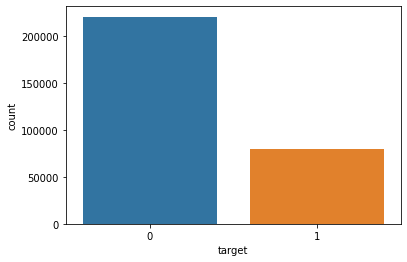

In [14]:
sns.countplot(ds.target);

In [15]:
ds.head(3)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0


### ----------metrics------------

In [16]:
def print_metrics(actual, predict, title=''):
    precision = precision_score(actual, predict)
    recall = recall_score(actual, predict)
    f1 = f1_score(actual, predict)
        
    print('-'*15, title, '-'*15)
    print(f'Precision - {precision}')
    print(f'Recall    - {recall}')
    print(f'F1 score  - {f1}')
    print('-'*35)

In [17]:
def plot_roc_auc_curve(actual, predict):
    fpr, tpr, threshold = roc_curve(actual, predict)
    roc_auc = roc_auc_score(actual, predict)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, c='b')
    plt.plot([0, 1], [0, 1], c='red')
    plt.title(f'ROC AUC {roc_auc}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### ---------------Transform--------------

In [18]:
ds_transf = ds.copy(deep=True)

In [19]:
# ds_transf.cont9 = np.log1p(ds_transf.cont9)

In [20]:
# ds_transf = pd.get_dummies(ds_transf, prefix_sep='_', columns=columns_cat, drop_first=True)

In [21]:
le = LabelEncoder()

In [22]:
for col in columns_cat:
    ds_transf[col] = le.fit_transform(ds_transf[col])

In [23]:
ds_transf.drop(['id', 'target'], axis=1, inplace=True)

In [24]:
ds_transf.shape, ds.shape

((300000, 30), (300000, 32))

In [25]:
scaler = StandardScaler()

In [26]:
ds_transf = scaler.fit_transform(ds_transf)

In [27]:
ds_transf = normalize(ds_transf)

In [28]:
ds_transf = pd.DataFrame(ds_transf)

### --------------Cluster-------------

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

In [36]:
tsne = TSNE(perplexity=50, n_jobs=-1)

In [37]:
%%time
tsne_df = tsne.fit_transform(ds_transf_short)

CPU times: user 18min 2s, sys: 20.1 s, total: 18min 22s
Wall time: 3min 2s


In [38]:
tsne_df.shape

(30000, 2)

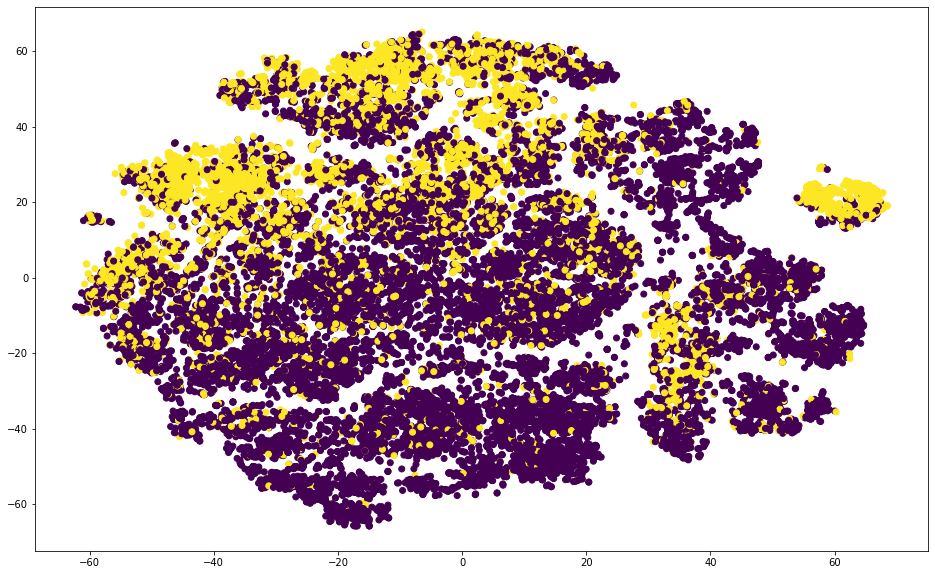

In [39]:
plt.figure(figsize=(16, 10))
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c=ds.loc[index_short].target);

In [40]:
dist = pdist(ds_transf_short)

In [41]:
Z = hierarchy.linkage(dist, 'ward')

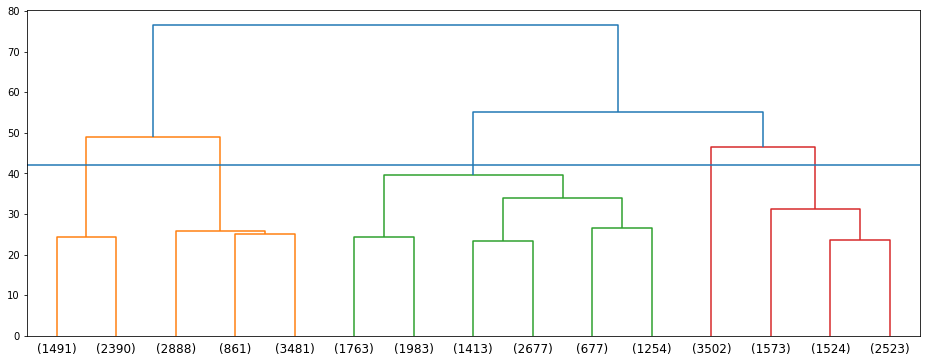

In [44]:
plt.figure(figsize=(16, 6))
hierarchy.dendrogram(Z, truncate_mode='lastp', p=15)
plt.axhline(y=42)
plt.show()

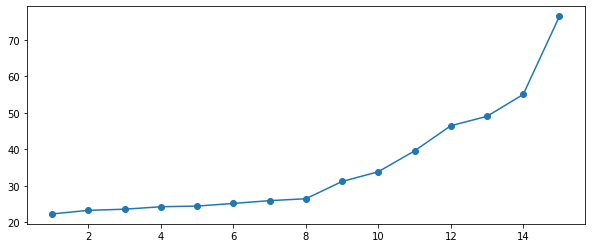

In [66]:
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(Z[-15:, 2])+1), Z[-15:, 2], marker='o')

In [50]:
silhuette = []
k = range(2, 16)
for i in k:
    km = KMeans(n_clusters=i, n_jobs=-1)
    km.fit(ds_transf_short)    
    silhuette.append(silhouette_score(ds_transf_short, km.labels_))

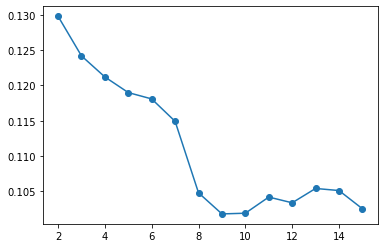

In [51]:
plt.plot(k, silhuette, marker='o')

In [63]:
km = KMeans(n_clusters=6, n_jobs=-1)
km.fit(ds_transf_short)

KMeans(n_clusters=6, n_jobs=-1)

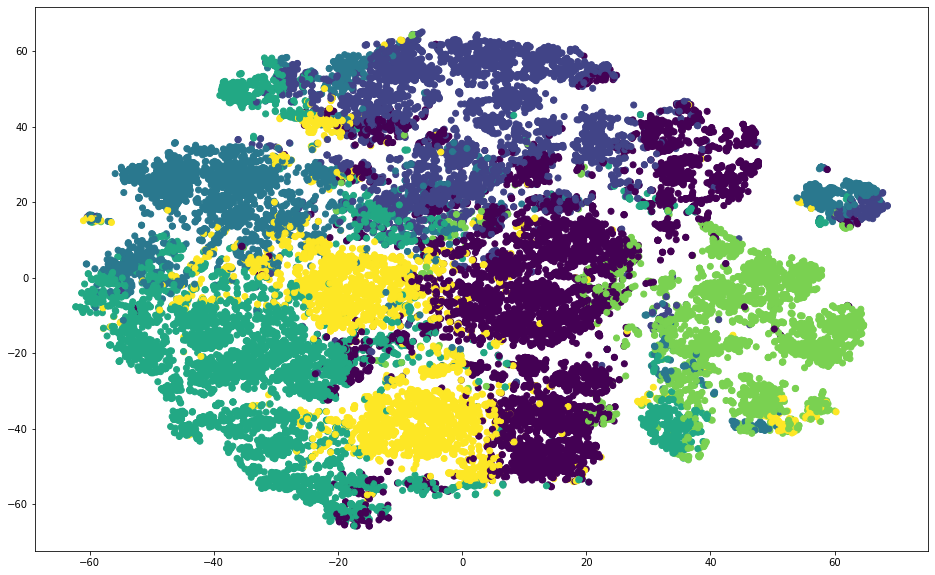

In [64]:
plt.figure(figsize=(16, 10))
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c=km.labels_);

#### ----------------SHORT------------------

In [29]:
ds_transf.shape

(300000, 30)

In [30]:
# ds_transf.reset_index(inplace=True)
# ds_transf.drop('id', axis=1, inplace=True)
# ds_transf.head(3)

In [31]:
index_all = ds_transf.index

In [32]:
size_row = int(ds_transf.shape[0] / 10)
index_short = np.random.choice(index_all, size_row, replace=False)
index_short.shape

(30000,)

In [33]:
ds_transf_short = ds_transf.loc[index_short]
ds_transf_short.shape

(30000, 30)

In [34]:
ds_transf_short.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
57480,-0.148601,0.238039,-0.038473,0.082422,0.032424,0.066297,-0.151587,0.082190,-0.259532,-0.147866,...,0.084328,-0.092813,-0.222377,-0.232479,-0.151148,0.054010,-0.087369,-0.143912,-0.175485,-0.090250
120637,-0.108632,0.113542,0.106576,-0.096594,-0.221170,-0.405138,0.064799,-0.127250,0.054614,0.228420,...,-0.255572,-0.240650,0.080729,-0.162009,0.178333,-0.131847,-0.272891,-0.125213,0.306301,-0.259616
138987,-0.102118,-0.006958,-0.110853,-0.090801,0.022281,0.045559,0.225996,0.106794,-0.049724,0.531057,...,0.126103,0.042862,-0.133197,-0.205209,-0.197887,0.072890,-0.040523,-0.105424,0.019869,-0.021358


### -------------models-----------------

In [30]:
model_RF = RandomForestClassifier(n_estimators=1500, criterion='entropy', max_leaf_nodes=None, 
                                  max_features='auto', bootstrap=True, random_state=78, n_jobs=-1)

In [ ]:
%%time
print(time.strftime('%X'), end='|')
model_RF.fit(model_RF.fit(X=ds_transf.drop(['id', 'target'], axis=1), y=ds_transf.target))

15:45:52|

### ----------------TEST-----------------

In [27]:
ds_test = pd.read_csv('test.csv')

In [28]:
ds_test_transf = ds_test.copy(deep=True)

In [29]:
ds_test_transf.cont9 = np.log1p(ds_test_transf.cont9)

In [30]:
ds_test_transf = pd.get_dummies(ds_test_transf, prefix_sep='_', columns=columns_cat)

In [31]:
ds_test_transf.shape, ds_transf.shape

((200000, 631), (441078, 617))

In [32]:
columns_train_transf = ds_transf.drop(['id', 'target'], axis=1).columns
columns_test_transf = ds_test_transf.drop(['id'], axis=1).columns

In [33]:
add_columns_to_test = [col for col in columns_train_transf if col not in columns_test_transf]

In [34]:
add_columns_to_test

['cat10_AW',
 'cat10_BS',
 'cat10_CH',
 'cat10_CX',
 'cat10_FW',
 'cat10_GH',
 'cat10_IL',
 'cat10_JF',
 'cat10_LK',
 'cat10_MK',
 'cat10_MO',
 'cat10_MW']

In [35]:
ds_test_transf[add_columns_to_test] = 0

In [36]:
ds_test_transf[add_columns_to_test].head(3)

,cat10_AW,cat10_BS,cat10_CH,cat10_CX,cat10_FW,cat10_GH,cat10_IL,cat10_JF,cat10_LK,cat10_MK,cat10_MO,cat10_MW
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
ds_transf[columns_train_transf].head(3)

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat15_D,cat16_B,cat16_C,cat16_D,cat17_B,cat17_C,cat17_D,cat18_B,cat18_C,cat18_D
290362,0.573887,0.685103,0.675870,0.324522,0.729918,0.684258,0.714397,0.362458,0.317510,0.247155,...,0,0,0,1,0,0,1,1,0,0
72429,0.540947,0.939383,0.840716,0.311353,0.196831,0.794648,0.888301,0.404780,0.987549,0.435667,...,1,1,0,0,0,0,1,1,0,0
256789,0.426058,0.586212,0.602429,0.655739,0.366462,0.767076,0.257480,0.510600,0.640428,0.287288,...,0,0,0,1,0,0,1,1,0,0


In [38]:
ds_test_transf[columns_train_transf].head(3)

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat15_D,cat16_B,cat16_C,cat16_D,cat17_B,cat17_C,cat17_D,cat18_B,cat18_C,cat18_D
0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.307475,...,0,0,0,1,0,0,1,1,0,0
1,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.448218,...,1,1,0,0,0,0,1,1,0,0
2,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.224973,...,0,0,0,1,0,0,1,1,0,0


In [39]:
ds_transf[columns_train_transf].shape, ds_test_transf[columns_train_transf].shape

((441078, 615), (200000, 615))

In [41]:
%%time

preds = np.zeros(ds_test_transf.shape[0])

kf = StratifiedKFold(n_splits=4 , random_state=0 , shuffle=True)
roc = []
n = 0
for trn_idx , val_idx in kf.split(ds_transf[columns_train_transf] , ds_transf.target):
    train_x = ds_transf[columns_train_transf].iloc[trn_idx]
    train_y = ds_transf.target.iloc[trn_idx]
    val_x = ds_transf[columns_train_transf].iloc[val_idx]
    val_y = ds_transf.target.iloc[val_idx]
    
    model_RF = RandomForestClassifier(n_estimators=1500, criterion='entropy', max_leaf_nodes=None, 
                                      max_features='auto', bootstrap=True, random_state=78, n_jobs=-1)
        
    print(time.strftime('%X'), end='-')    
    
    model_RF.fit(train_x , train_y)
    
    preds += model_RF.predict_proba(ds_test_transf[columns_train_transf])[:, 1]/kf.n_splits
    
    roc.append(roc_auc_score(val_y , model_RF.predict_proba(val_x)[:,1]))
    print(n+1 , roc[n])
    n+=1

19:29:05-1 0.9654687692918004
20:03:57-2 0.9657118809812882
20:39:39-3 0.9647174974827154
21:15:15-4 0.9652898246122099
CPU times: user 13h 50min 58s, sys: 14min 14s, total: 14h 5min 13s
Wall time: 2h 21min 45s


In [43]:
ds_test_transf['target'] = preds

In [44]:
answer = ds_test_transf[['id', 'target']]

In [45]:
answer.to_csv('answer_10_(31_03_21)_RF_my_1500_fold4.csv', index=False)

In [ ]:
!sudo shutdown -h now